# **BERT Sentiment analysis**



## Notebook preparation

### Setup connection to Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Web Mining/'

/content/drive/My Drive/Web Mining


### install relevant packages

In [3]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 3.3MB 30.2MB/s 
     |████████████████████████████████| 901kB 32.4MB/s 


### import relevant libraries

In [4]:
import os
import torch
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torch.nn.functional as F

### setup gpu for training if it is available

In [5]:
# Check if a GPU can be used
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not assign CPU
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Define run settings of notebook

Four different settings can be changed for the data preparation and training of the current notebook:


* Specify BERT Model (tested on: **bert_base_uncased**)
* Split lyrics with sliding window
* Specify Dataset
* Preprocess lyrics tags (will only be used for the dataset with commas for line breaks)

In [6]:
# specify name of model
pretrained_model_name = 'bert-base-uncased'

# define if lyrics should be splitted with sliding window to prevent reduction of tokens
split_lyrics = True

# specify dataset that will be used for training
file_name = 'Classes_Dataset/all_songs_lyrics_comma_classes.csv' # Classes_Dataset/all_songs_preprocessed_classes.csv

# preprocess lyrics tags (if dataset is included with comma)
if file_name == 'Classes_Dataset/all_songs_preprocessed_classes.csv':
  preprocess_lyrics = False # Does not need to be changed as in this dataset preprocessing was already done
else:
  preprocess_lyrics = True # Can be set to false, but was not tested

# define how many epochs we want to train
EPOCHS = 5

# define how many classes can be chosen
num_classes = 3

In [7]:
# define random settings for reproducability
random_seed = 46
torch.manual_seed(random_seed)

## Data Preparation


### Load data

Print basic structure of dataframe to get overall understanding of the data

In [8]:
data = pd.read_csv(file_name)

if num_classes == 2:
  data = data[['lyrics', 'sentiment_2classes']]
  data = data.dropna()
elif num_classes == 3:
  data = data[['lyrics', 'sentiment_3classes']]
else:
  raise ValueError(f'Specify num_classes variable instead of {num_classes} to either 2 or 3')

data.columns = ['lyrics', 'sentiment']

print(data.columns)
print(data.head(5))

Index(['lyrics', 'sentiment'], dtype='object')
                                              lyrics  sentiment
0  [Chorus: The Charmaines],Let's make this Chris...          0
1  Come over baby whole lot of shakin' goin' on,,...          2
2  [Verse 1],I sit alone in my bedroom,Starin' at...          2
3  [Intro],Ooh,,[Verse 1],Can you feel me when I ...          1
4  [Verse 1],One day when I came home at lunchtim...          2


### Replace information parts within lyrics


> Parts in which f.e. Chorus or Verse is marked within dataset (New part will be marked with an point, linebreaks with a comma



In [9]:
def preprocess(lyrics):
  lyrics = re.sub(r'\[.*?\]', '.', lyrics) # replace Information brackets with point to mark end of logical part in a song
  lyrics = re.sub(r'^(,*\.,*)', '', lyrics) # replace dots and commas at beginning of song
  return re.sub(r'(,*\.,*)', '.', lyrics) # replace sequence of commas before and after a point with a single point

if preprocess_lyrics is True:
  data['lyrics_pre'] = data.lyrics.apply(preprocess)

### define sliding window
Idea is to not truncate lyrics as important information might get missed


> Sliding window is defined by a window size of 200 words and incorporation 50 words from before to add context to sliding window



In [10]:
# define method for sliding window
def get_split(lyrics):
  data = []
  partial = []
  if len(lyrics.split())//150 >0:
    n = len(lyrics.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      partial = lyrics.split()[:200]
      data.append(" ".join(partial))
    else:
      partial = lyrics.split()[w*150:w*150 + 200]
      data.append(" ".join(partial))
  return data

In [11]:
# check if lyrics will be splitted
if split_lyrics is True:
  if preprocess_lyrics is True:
    data['lyrics_split'] = data['lyrics_pre'].apply(get_split)
  else:
    data['lyrics_split'] = data['lyrics'].apply(get_split)
  # define list for reconstructing dataframe
  train = []
  label = []
  index =[]
  # iterate through list to split list in one column into multiple rows
  for idx,row in data.iterrows():
    for element in row['lyrics_split']:
      train.append(element)
      label.append(row['sentiment'])
      index.append(idx)
  data = pd.DataFrame({'lyrics': train, 'sentiment': label})
else:
  data = data[['lyrics', 'sentiment']]

In [12]:
data

,lyrics,sentiment
0,Let's make this Christmas mean something this ...,0
1,"Come over baby whole lot of shakin' goin' on,,...",2
2,"I sit alone in my bedroom,Starin' at the walls...",2
3,"Ooh.Can you feel me when I think about you?,Wi...",1
4,"One day when I came home at lunchtime,I heard ...",2
...,...,...
21683,"see it,She'll make the first move, smooth, int...",1
21684,"(down, down).Baby, whatever you want, girl, yo...",1
21685,"That lipstick on your collar, well, it ain't m...",1
21686,"When you get caught in the rain,With nowhere t...",1


### split data in train, validation and test dataset



In [13]:
# ratio for training and test data split
ratio_test = 0.2
# define random seed to get same result for the training and test data
data_train, data_test, target_train, target_test = train_test_split(data['lyrics'], data['sentiment'], test_size=ratio_test, random_state=random_seed, shuffle=True)
data_val, data_test, target_val, target_test = train_test_split(data_test, target_test, test_size=0.5, random_state=random_seed, shuffle=True)

# Check splits
print(f'Train size: {len(target_train)}')
print(f'Test size: {len(target_test)}')
print(f'Validation size: {len(target_val)}')
# Check balance of different subsets
print(10*'-')
if num_classes == 2:
  print(f'Train size positive: {np.sum(target_train==1)}')
  print(f'Train size neutral: {np.sum(target_train==2)}')
  print(f'Train size negative: {np.sum(target_train==0)}')
  print(f'Test size positive: {np.sum(target_test==1)}')
  print(f'Test size neutral: {np.sum(target_test==2)}')
  print(f'Test size negative: {np.sum(target_test==0)}')
  print(f'Validation size positive: {np.sum(target_val==1)}')
  print(f'Validation size neutral: {np.sum(target_val==2)}')
  print(f'Validation size negative: {np.sum(target_val==0)}')
elif num_classes == 3:
  print(f'Train size positive: {np.sum(target_train==2)}')
  print(f'Train size neutral: {np.sum(target_train==1)}')
  print(f'Train size negative: {np.sum(target_train==0)}')
  print(f'Test size positive: {np.sum(target_test==2)}')
  print(f'Test size neutral: {np.sum(target_test==1)}')
  print(f'Test size negative: {np.sum(target_test==0)}')
  print(f'Validation size positive: {np.sum(target_val==2)}')
  print(f'Validation size neutral: {np.sum(target_val==1)}')
  print(f'Validation size negative: {np.sum(target_val==0)}')

Train size: 17350
Test size: 2169
Validation size: 2169
----------
Train size positive: 5843
Train size neutral: 5576
Train size negative: 5931
Test size positive: 771
Test size neutral: 657
Test size negative: 741
Validation size positive: 724
Validation size neutral: 712
Validation size negative: 733


### Tokenizer



#### Load Tokenizer

In [14]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name, do_lower_case=True)

Loading BERT tokenizer...


#### Build Dataset for training

In [15]:
# Construct DataLoader class to transform data to DataLoader object
class LyricsDataset(Dataset):

  def __init__(self, lyrics, labels, tokenizer, max_len):
    self.lyrics = lyrics
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.lyrics)

  def __getitem__(self, idx):
    lyrics = str(self.lyrics[idx])
    label = self.labels[idx]
    encoding = self.tokenizer.encode_plus(
      lyrics,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]' and [PAD]
      max_length=self.max_len, # Pad & truncate all texts
      pad_to_max_length=True,
      return_token_type_ids=False,
      return_attention_mask=True, # Construct attention masks
      return_tensors='pt', # Return pytorch tensors
    )
    return {
      'lyrics_text': lyrics,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [16]:
# which help us to customizing data loading order and do automatic batching
def create_data_loader(X, Y, tokenizer, max_len, batch_size, num_workers=2, sampler = None):
  ds = LyricsDataset(
    lyrics=np.array(X),
    labels=np.array(Y),
    tokenizer=tokenizer,
    max_len=max_len
  )
  if sampler!=None:
    sampler = sampler(ds)

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=num_workers,
    sampler = sampler
  )

In [17]:
MAX_LEN = 256
BATCH_SIZE = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_data_loader = create_data_loader(data_train, target_train, tokenizer, MAX_LEN, BATCH_SIZE, sampler = RandomSampler) # Select batches randomly
val_data_loader = create_data_loader(data_val, target_val, tokenizer, MAX_LEN, BATCH_SIZE, sampler = RandomSampler) # Pull out batches sequentially.
test_data_loader = create_data_loader(data_test, target_test, tokenizer, MAX_LEN, BATCH_SIZE, sampler = RandomSampler) # Pull out batches sequentially.

## Modelling

### Load model

In [18]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name,
    num_labels = num_classes, # output labels specified in the num_classes variable
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the specified device
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### Define optimizer

In [20]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [21]:
# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_data_loader) * EPOCHS

# Create the learning rate scheduler, here we use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Define our loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [22]:
# Training
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model.train()
  total_train_accuracy = 0
  total_train_loss = 0
  losses = []
  correct_predictions = 0
  for step, batch in enumerate(data_loader):
    if step % 40 == 0 and not step == 0:
       print('Batch: {}  of  {}'.format(step, len(data_loader)))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    model.zero_grad()
    outputs = model(
      input_ids=input_ids,
      token_type_ids=None,
      attention_mask=attention_mask,
      labels=labels
    )
    loss = outputs[0]
    total_train_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    logits = outputs[1].detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    total_train_accuracy += flat_accuracy(logits, label_ids)
  # Calculate the average loss over all of the batches.
  avg_train_accuracy = total_train_accuracy / len(data_loader)
  avg_train_loss = total_train_loss / len(data_loader) 
  return avg_train_accuracy, avg_train_loss

In [23]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
# Evaluation
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model.eval()
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        token_type_ids=None,
        attention_mask=attention_mask,
        labels=labels
      )
      total_eval_loss += outputs[0].item()
      logits = outputs[1].detach().cpu().numpy()
      label_ids = labels.to('cpu').numpy()
      total_eval_accuracy += flat_accuracy(logits, label_ids)

  avg_val_accuracy = total_eval_accuracy / len(data_loader)
  avg_val_loss = total_eval_loss / len(data_loader)
  return avg_val_accuracy, avg_val_loss

In [25]:
%%time

from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print('Epoch: {}/{}'.format(epoch+1, EPOCHS))
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(data_train)
  )
  print('Train loss: {}, Accuracy: {}'.format(train_loss, train_acc))
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(data_val)
  )
  print('Val loss: {}, Accuracy: {}'.format(val_loss, val_acc))
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  model_save_name = 'model_epoch' + str(epoch+1) + '.bin'
  torch.save(model.state_dict(), model_save_name)

  if val_acc > best_accuracy:
    print('Epoch: ', str(epoch+1))
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch: 1/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Batch: 40  of  543
Batch: 80  of  543
Batch: 120  of  543
Batch: 160  of  543
Batch: 200  of  543
Batch: 240  of  543
Batch: 280  of  543
Batch: 320  of  543
Batch: 360  of  543
Batch: 400  of  543
Batch: 440  of  543
Batch: 480  of  543
Batch: 520  of  543
Train loss: 1.0340359198893412, Accuracy: 0.4541896869244936


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val loss: 0.9869430748855367, Accuracy: 0.5102757352941176

Epoch:  1
Epoch: 2/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Batch: 40  of  543
Batch: 80  of  543
Batch: 120  of  543
Batch: 160  of  543
Batch: 200  of  543
Batch: 240  of  543
Batch: 280  of  543
Batch: 320  of  543
Batch: 360  of  543
Batch: 400  of  543
Batch: 440  of  543
Batch: 480  of  543
Batch: 520  of  543
Train loss: 0.9561085727333364, Accuracy: 0.5279696132596685


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Val loss: 0.9677411615848541, Accuracy: 0.5234558823529412

Epoch:  2
Epoch: 3/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Batch: 40  of  543
Batch: 80  of  543
Batch: 120  of  543
Batch: 160  of  543
Batch: 200  of  543
Batch: 240  of  543
Batch: 280  of  543
Batch: 320  of  543
Batch: 360  of  543
Batch: 400  of  543
Batch: 440  of  543
Batch: 480  of  543
Batch: 520  of  543
Train loss: 0.8162270877681823, Accuracy: 0.6263620319214241


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Val loss: 0.9925625350545434, Accuracy: 0.5425735294117647

Epoch:  3
Epoch: 4/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Batch: 40  of  543
Batch: 80  of  543
Batch: 120  of  543
Batch: 160  of  543
Batch: 200  of  543
Batch: 240  of  543
Batch: 280  of  543
Batch: 320  of  543
Batch: 360  of  543
Batch: 400  of  543
Batch: 440  of  543
Batch: 480  of  543
Batch: 520  of  543
Train loss: 0.6372326280420876, Accuracy: 0.7278813689379987


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Val loss: 1.1080659347421982, Accuracy: 0.5228125

Epoch: 5/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Batch: 40  of  543
Batch: 80  of  543
Batch: 120  of  543
Batch: 160  of  543
Batch: 200  of  543
Batch: 240  of  543
Batch: 280  of  543
Batch: 320  of  543
Batch: 360  of  543
Batch: 400  of  543
Batch: 440  of  543
Batch: 480  of  543
Batch: 520  of  543
Train loss: 0.5103043796662687, Accuracy: 0.7974409146715777


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val loss: 1.2033220748690998, Accuracy: 0.5243198529411766

CPU times: user 36min 49s, sys: 15.1 s, total: 37min 4s
Wall time: 37min 36s


In [26]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(data_test)
)
print(f'Testing Accuracy: {test_acc.item()}')
print(f'Testing Loss: {test_loss}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Testing Accuracy: 0.5567463235294118
Testing Loss: 1.1627932567806805


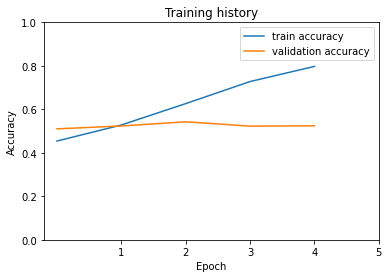

In [27]:
# Plot the accuracy for training and validation set
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.xticks(np.arange(1, 6, 1.0))
plt.ylim([0, 1]);

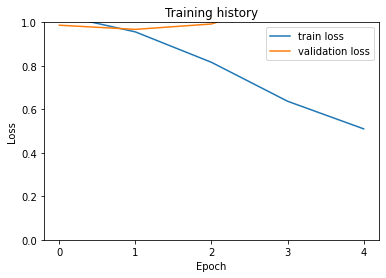

In [28]:
# Plot the accuracy for training and validation set
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.xticks(np.arange(0, 5, 1.0))
plt.ylim([0, 1]);

In [29]:
# How to save model
output_dir = f'./save_model_{pretrained_model_name}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
#Load a trained model and vocabulary that you have fine-tuned
# model = BertForSequenceClassification.from_pretrained(output_dir)
# tokenizer = BertTokenizer.from_pretrained(output_dir)

Saving model to ./save_model_bert-base-uncased


('./save_model_bert-base-uncased/tokenizer_config.json',
 './save_model_bert-base-uncased/special_tokens_map.json',
 './save_model_bert-base-uncased/vocab.txt',
 './save_model_bert-base-uncased/added_tokens.json',
 './save_model_bert-base-uncased/tokenizer.json')

In [30]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    lyrics_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["lyrics_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            lyrics_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return lyrics_texts, predictions, prediction_probs, real_values

In [31]:
y_lyrics_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

In [32]:
class_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.59      0.64      0.61       741
     neutral       0.47      0.50      0.48       657
    positive       0.61      0.53      0.57       771

    accuracy                           0.56      2169
   macro avg       0.56      0.55      0.55      2169
weighted avg       0.56      0.56      0.56      2169

